# EDA 당근 리뷰(소비자 리뷰만)

In [2]:
# 0) Package Import

# Data Processing
import numpy as np
import pandas as pd
import re

# NLP
from konlpy.tag import Okt # twitter dev
from konlpy.tag import Kkma # konlpy.tag : Okt, Kkma
from konlpy.utils import pprint
from kiwipiepy import Kiwi 

# Visualization
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# WordCloud
from PIL import Image
from wordcloud import WordCloud
from collections import Counter

# LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model 

# 장바구니 분석
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

## 1. Data Setting

In [3]:
# 1) Data 확인
raw_cus_data = pd.read_csv('data/구글플레이스토어_당근_리뷰.csv')
raw_sel_data = pd.read_csv('data/구글플레이스토어_배민사장님_리뷰.csv') # 미사용 데이터

# 결측치 및 type 확인
print(raw_cus_data.info()) # 400개(결측치 x, 연속성 data type 확인)
print(raw_sel_data.info()) # 560개(결측치 x, 연속성 data type 확인)

# ** 사용자 리뷰 640개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   640 non-null    int64 
 1   customer_id  640 non-null    object
 2   star         640 non-null    int64 
 3   enroll_date  640 non-null    object
 4   content      640 non-null    object
dtypes: int64(2), object(3)
memory usage: 25.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   560 non-null    int64 
 1   customer_id  560 non-null    object
 2   star         560 non-null    int64 
 3   enroll_date  560 non-null    object
 4   content      560 non-null    object
dtypes: int64(2), object(3)
memory usage: 22.0+ KB
None


In [4]:
# 2) 긍부정 column 추가(기준 Data 생성)
raw_cus_data['favor'] = np.where(raw_cus_data['star'] >= 4, 1, 0)
raw_sel_data['favor'] = np.where(raw_sel_data['star'] >= 4, 1, 0)

cus_data = raw_cus_data
sel_data = raw_sel_data

cus_list = cus_data['content'].tolist()
sel_list = sel_data['content'].tolist()

In [5]:
# 3) List로 추출(불용어 처리/유효성 검사)

okt = Okt()

stop_words = ['주문', '배달', '쿠폰', '메뉴', '어플', '결제', '가게', '사용', '배민', '리뷰', '기능', ] 

def make_word_list(content_list):

    word_list = []

    for content in content_list:

        # 1. 정규표현식 정제
        review = re.sub(r'[^0-9a-zA-Z가-힣\s+-]', '', content)

        # 2. 형태소 분석
        result = okt.nouns(review)

        for word in result:
            if len(word) > 1 and word not in stop_words:
                word_list.append(word)
                
    return word_list

cus_word_list = make_word_list(cus_list)
sel_word_list = make_word_list(sel_list)

print(len(cus_word_list))  
print(len(sel_word_list))        


17402
7354


## 2. 워드 클라우드 분석

In [7]:
def make_word_cloud(word_list, keyword_amount, title):
    
    counter = Counter(word_list).most_common(keyword_amount)

    circle_mask = np.array(Image.open(r'resources\circle.png'))

    wc = WordCloud(
        font_path=r"C:\Windows\Fonts\H2GTRM.TTF",
        background_color="black", # white
        mask=circle_mask,
        colormap="jet", # https://www.kaggle.com/code/niteshhalai/wordcloud-colormap
        width=1200,
        height=1200,
        scale=10 # 결과 이미지의 해상도를 높히고 싶을때 
    )

    wc.generate_from_frequencies(dict(counter))

    plt.figure(figsize=(5,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

c:\walker\code\eda-ddangyo\.venv\Lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


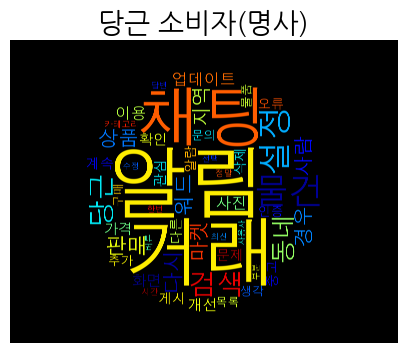

In [8]:
make_word_cloud(cus_word_list, 50, '당근 소비자(명사)')    

c:\walker\code\eda-ddangyo\.venv\Lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


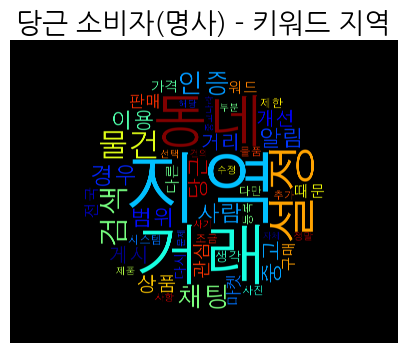

In [9]:
# 소비자 리뷰 중에서 특정 키워드가 들어간 리뷰들 워드 클라우드

cus_keyword = '지역'
cus_keyword_list = cus_data.loc[cus_data['content'].str.contains(cus_keyword),:]['content']

cus_keyword_word_list = make_word_list(cus_keyword_list)

make_word_cloud(cus_keyword_word_list, 50, f'당근 소비자(명사) - 키워드 {cus_keyword}')

## 3. 긍부정 분석

c:\walker\code\eda-ddangyo\.venv\Lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


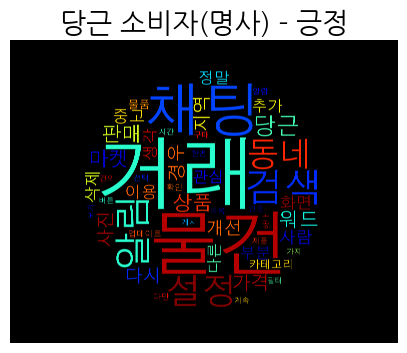

In [11]:
# 소비자 긍정 리뷰 분석

cus_pos_list = cus_data.loc[cus_data['favor'] == 1, :]['content']

cus_pos_word_list = make_word_list(cus_pos_list)

make_word_cloud(cus_pos_word_list, 50, '당근 소비자(명사) - 긍정')

In [12]:
# lda 데이터 전처리
def for_lda_data(content_list):

    lda_list = []

    for review in content_list:

        rv = re.sub(r"[^0-9a-zA-Z가-힣+-]", "", review)

        result = okt.morphs(rv)

        if result not in stop_words:
            lda_list.append(' '.join(result)) # vectorize를 위한 공백(' ') 구분 형태로 review 전처리
    
    return lda_list   

In [13]:
# 소비자 긍정 리뷰 lda
cus_pos_lda_list = for_lda_data(cus_pos_list)

vectorizer = CountVectorizer(
    max_df = 0.1,               # 전체 단어 등장 비율이 p 이상인 것만 사용할 것.
    min_df = 2,                 # 단어가 적어도 n개 이상인 것만 사용할 것.
    max_features = 1000,        # 상위 항목 n개만 사용할 것.
    ngram_range= (1,2)          # 단어(ngram)의 조합
)

feature_vec = vectorizer.fit_transform(cus_pos_lda_list)
feature_vec.shape

lda = LatentDirichletAllocation(n_components=3)
lda.fit(feature_vec)

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, feature_vec, vectorizer)
pyLDAvis.display(vis)

c:\walker\code\eda-ddangyo\.venv\Lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


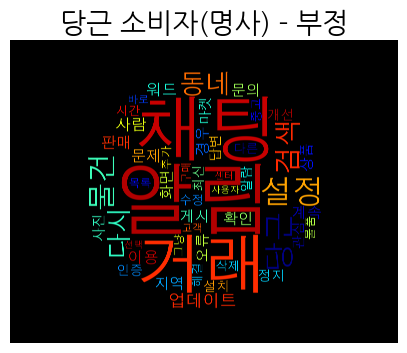

In [14]:
# 소비자 부정 리뷰 분석

cus_neg_list = cus_data.loc[cus_data['favor'] == 0, :]['content']

cus_neg_word_list = make_word_list(cus_neg_list)

make_word_cloud(cus_neg_word_list, 50, '당근 소비자(명사) - 부정')

In [15]:
# 소비자 부정 리뷰 lda
cus_neg_lda_list = for_lda_data(cus_neg_list)

vectorizer = CountVectorizer(
    max_df = 0.1,               # 전체 단어 등장 비율이 p 이상인 것만 사용할 것.
    min_df = 2,                 # 단어가 적어도 n개 이상인 것만 사용할 것.
    max_features = 1000,        # 상위 항목 n개만 사용할 것.
    ngram_range= (1,2)          # 단어(ngram)의 조합
)

feature_vec = vectorizer.fit_transform(cus_neg_lda_list)
feature_vec.shape

lda = LatentDirichletAllocation(n_components=3)
lda.fit(feature_vec)

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, feature_vec, vectorizer)
pyLDAvis.display(vis)

## 4. 장바구니 분석

In [16]:
# 1. [[],[],[]] 형태로 담기

def for_double_array_data(content_list):
    
    main_list = []

    for rv in content_list:
        sub_list = []

        re_rv = re.sub(r'[^0-9a-zA-Z가-힣\s+-]', '', rv)

        noun_list = okt.nouns(re_rv)

        for word in noun_list:
            if len(word) > 1:
                sub_list.append(word)

        main_list.append(sub_list)
        
    return main_list

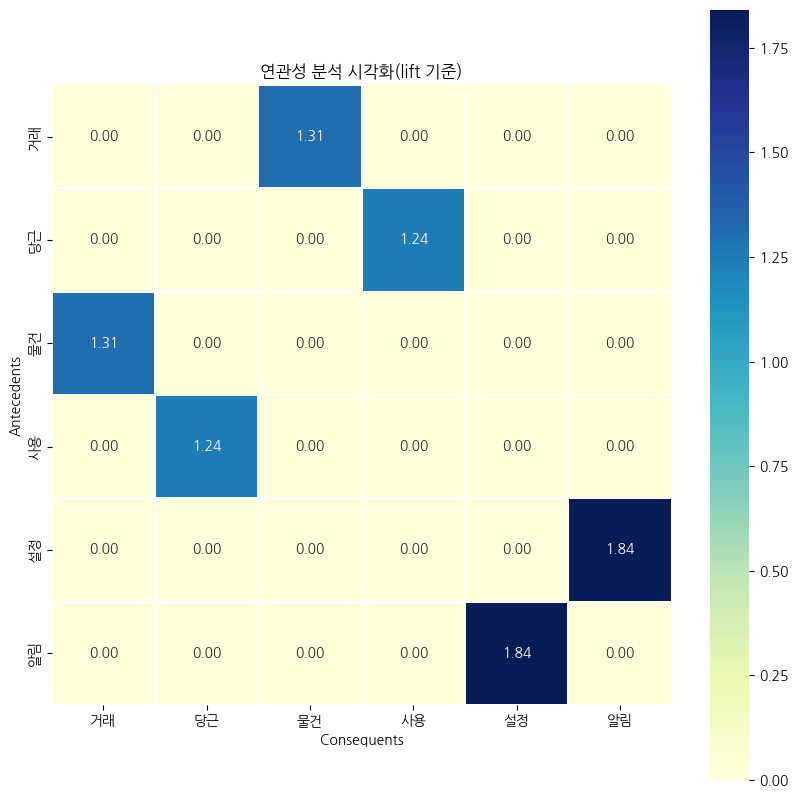

In [17]:
# heatmap 그리기

main_list = for_double_array_data(cus_list)

te = TransactionEncoder()
te_arr = te.fit(main_list).transform(main_list)
df = pd.DataFrame(te_arr, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True, max_len=2)
frequent_itemsets

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

rules["antecedents_str"] = rules["antecedents"].apply(lambda x: ",".join(sorted(list(x))))
rules["consequents_str"] = rules["consequents"].apply(lambda x: ",".join(sorted(list(x))))

rules[["antecedents_str", "consequents_str", "support", "confidence", "lift"]]

pivot_data = rules.pivot_table(
    index="antecedents_str",
    columns="consequents_str",
    values="lift", # 'confidence'
    fill_value=0
)

plt.figure(figsize=(10,10))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.3, square=True)
plt.title("연관성 분석 시각화(lift 기준)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.show()

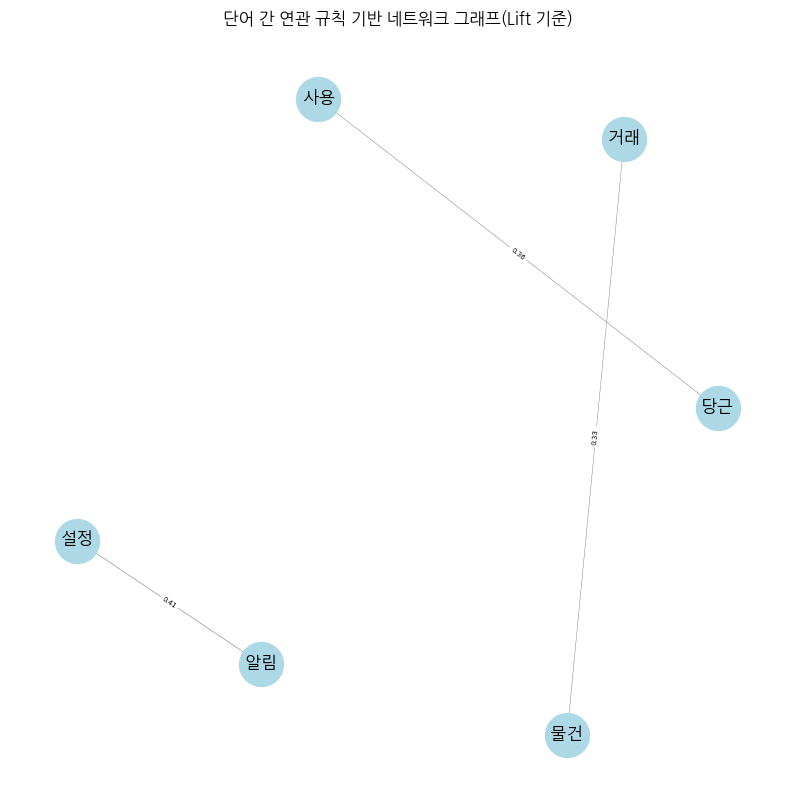

In [18]:
# 네트워크 분석

# 1. 그래프 생성
G = nx.Graph()

# 2. 엣지 추가
for _, row in rules.iterrows():
    # 단어 추출
    antecedent = ",".join(row["antecedents"])
    consequent = ",".join(row["consequents"])
    weight = row["confidence"]

    # 노드 추가
    G.add_edge(antecedent, consequent, weight=weight)

# 3. 노드 배치
# pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, seed=13, k=2) # k가 노드간 분산되게 해줌

# 4. 가중치 추출 
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]

# 5. 노드 스타일 지정 및 그리기
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=1000) # 점
nx.draw_networkx_edges(G, pos, edge_color="gray", width=edge_weights) # 선
nx.draw_networkx_labels(G, pos, font_size=12, font_family="Malgun Gothic")

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)

plt.title("단어 간 연관 규칙 기반 네트워크 그래프(Lift 기준)")
plt.axis("off")
plt.show()    

## 5. ML 예측